# ChemVAE

The training of the model that appears in the `../weights` directory can be replicated using the following commands in the command line:

```bash
python.exe main.py -i '../data/zinc.csv' -t 100000 -v 1000 -c 'SMILES' >> stdout/SMILES.txt
```

```bash
python.exe main.py -i '../data/zinc.csv' -t 100000 -v 1000 -c 'SELFIES' >> stdout/SELFIES.txt
```

The weights of the trained models are stored in the `../weights/SMILES/79_20211218-054436_checkpoint.pth` and `../weights/SELFIES/99_20211218-134027_checkpoint.pth` folders for SMILES and SELFIES, respectively.

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import pickle
import matplotlib.pyplot as plt
import random
import selfies as sf
# import time

from evaluate import plot_loss, plot_accuracy, plot_components, generate_statistics
from model import ConvEncoder, GRUDecoder, ChemVAE
from utils import import_data, return_splits, convert_num2str

%matplotlib inline

## Loss and Accuracy

### SMILES Data

In [2]:
path_smiles_char2idx = '../data/SMILES_char2idx_dict.pkl'
path_smiles_history = '../data/SMILES_history_dict.pkl'

with open(path_smiles_char2idx, 'rb') as f:
    smiles_char2idx = pickle.load(f)
    
with open(path_smiles_history, 'rb') as f:
    smiles_history = pickle.load(f)

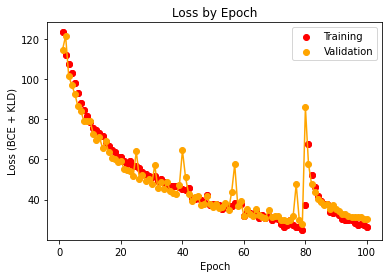

In [3]:
plot_loss(smiles_history, '../images/SMILES_loss.png')

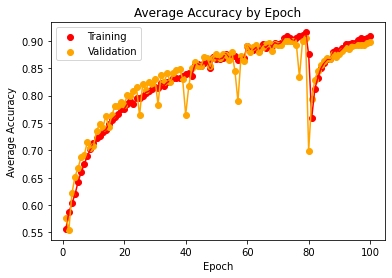

In [4]:
plot_accuracy(smiles_history, '../images/SMILES_accuracy.png')

C:\Users\jessb\OneDrive\PhD\NYU\Deep Learning\project\github\src\evaluate.py:56: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show();


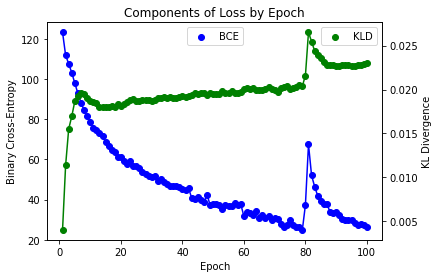

In [5]:
plot_components(smiles_history, '../images/SMILES_components.png')

### SELFIES Data

In [6]:
path_selfies_char2idx = '../data/SELFIES_char2idx_dict.pkl'
path_selfies_history = '../data/SELFIES_history_dict.pkl'

with open(path_selfies_char2idx, 'rb') as f:
    selfies_char2idx = pickle.load(f)

with open(path_selfies_history, 'rb') as f:
    selfies_history = pickle.load(f)

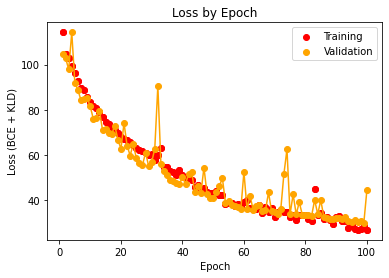

In [7]:
plot_loss(selfies_history, '../images/SELFIES_loss.png')

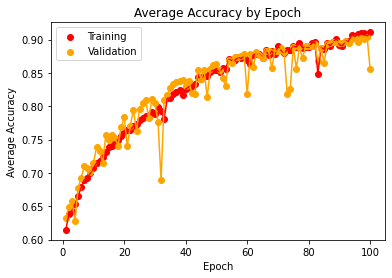

In [8]:
plot_accuracy(selfies_history, '../images/SELFIES_accuracy.png')

C:\Users\jessb\OneDrive\PhD\NYU\Deep Learning\project\github\src\evaluate.py:56: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show();


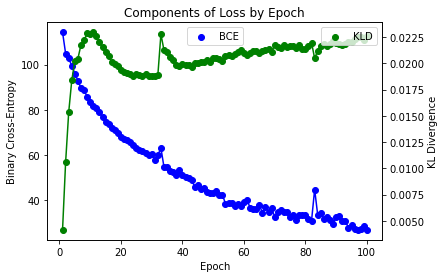

In [9]:
plot_components(selfies_history, '../images/SELFIES_components.png')

## Evaluation of Generative Data

In [10]:
data_path = '../data/zinc.csv'
df = import_data(data_path)

# set seed in pd.sample and extracting first rows
smiles_train, _ = return_splits(df, n_train=100000, n_test=1000, col_chem='SMILES')
selfies_train, _ = return_splits(df, n_train=100000, n_test=1000, col_chem='SELFIES')

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# number of samples generated from normal distribution
n_samples = 1000

### SMILES Data

In [11]:
# load pre-trained SMILES weights
path_smiles_weights = '../weights/SMILES/79_20211218-054436_checkpoint.pth'

n_latent = 488
#TODO make this dynamic not hardcoded
n_length = 60
n_char = len(smiles_char2idx)

smiles_idx2char = {y:x for x,y in smiles_char2idx.items()}

enc_smiles = ConvEncoder(n_latent, n_length, n_char).to(device)
dec_smiles = GRUDecoder(n_latent, n_length, n_char).to(device)
model_smiles = ChemVAE(enc_smiles, dec_smiles).to(device)

model_smiles.load_state_dict(torch.load(path_smiles_weights))

<All keys matched successfully>

In [12]:
# code adapted from http://bits.csb.pitt.edu/mscbio2066/assign7/eval.py
torch.manual_seed(123)

z_1 = torch.normal(0, 1, size=(1, n_latent),device=device)
with torch.no_grad():
    model_smiles.decode.eval()
    traced_smiles = torch.jit.trace(model_smiles.decode, z_1.to(device))
    #torch.jit.save(traced,args.out)

with torch.no_grad():
    # to visualize string at mean = 0 
    z = torch.zeros((1, n_latent), device=device)
    output_smiles = traced_smiles(z)
    output_smiles = list(output_smiles.argmax(axis=2).cpu().numpy())
    zsmiles = [convert_num2str(i, smiles_idx2char) for i in output_smiles][0]

    # convert n_samples randomly generated from std normal to SMILES
    z_1 = torch.normal(0, 1, size=(n_samples, n_latent), device=device)
    output_smiles = traced_smiles(z_1)
    output_smiles = list(output_smiles.argmax(axis=2).cpu().numpy())
    output_smiles = [convert_num2str(i, smiles_idx2char) for i in output_smiles]

In [13]:
valid_smiles, unique_mols, novelcnt, ringave, valid_list = generate_statistics(output_smiles, smiles_train)

In [14]:
valid_list

['N#Cc1ccc(C(=O)OCc2ccc3cccccc3Cs2)s1',
 'COOC(=O)c1cccc11S(=O)n11CONC1OO',
 'B',
 'F']

In [15]:
# print("GenerateTime",duration)
print("UniqueSmiles", len(set(output_smiles)))
print("ValidSmiles", valid_smiles)
print("UniqueAndValidMols", unique_mols)
print("NovelMols", novelcnt)
print("AverageRings", ringave)
print("SMILE",zsmiles)

UniqueSmiles 637
ValidSmiles 4
UniqueAndValidMols 4
NovelMols 4
AverageRings 1.5
SMILE N#CCn1c(())c(C))cc2cc2ccccccco1CO2


In [16]:
i = 0
num_valid = 0

demo_smiles = []
while num_valid < 10:
    if output_smiles[i] != '':
        demo_smiles.append(output_smiles[i])
        num_valid += 1
    i += 1
        
for smiles in demo_smiles:
    print(smiles)

CC(C(=O)c1ccccNS(=O)c1cccc2cccccnnnn1
r
r
CCcc1ccc(NNN((NNc22ccc(NCCCnnc3n2))c1
COCCc1cc2cc((=O)c(CC)c(Ccc22O))c1OC
CCCC)nnnn(C(=O)Nc2n((BCccs32n1
C1C1ncc(NCC)CCnc2cccccc(CCCC)n)C21
Nc1cc(N)c2cc(N((Fcc((O))c3cncnnnC1
NOCC(CC(c2c((c(ccccc3C33nnnnCCCC
COCc1cc(C)))ccc1C(=O)11ccccc11CCC2


### SELFIES Data

In [17]:
# load pre-trained SELFIES weights
path_selfies_weights = '../weights/SELFIES/99_20211218-134027_checkpoint.pth'

n_latent = 488
#TODO make this dynamic not hardcoded
n_length = 60
n_char = len(selfies_char2idx)

selfies_idx2char = {y:x for x,y in selfies_char2idx.items()}

enc_selfies = ConvEncoder(n_latent, n_length, n_char).to(device)
dec_selfies = GRUDecoder(n_latent, n_length, n_char).to(device)
model_selfies = ChemVAE(enc_selfies, dec_selfies).to(device)

model_selfies.load_state_dict(torch.load(path_selfies_weights))

<All keys matched successfully>

In [18]:
# code adapted from http://bits.csb.pitt.edu/mscbio2066/assign7/eval.py
torch.manual_seed(123)

z_1 = torch.normal(0, 1, size=(1, n_latent),device=device)
with torch.no_grad():
    model_selfies.decode.eval()
    traced_selfies = torch.jit.trace(model_selfies.decode, z_1.to(device))
    #torch.jit.save(traced,args.out)
    
with torch.no_grad():
    # to visualize string at mean = 0 
    z = torch.zeros((1, n_latent), device=device)
    output_selfies = traced_selfies(z)
    output_selfies = list(output_selfies.argmax(axis=2).cpu().numpy())
    zselfies = [sf.decoder(convert_num2str(i, selfies_idx2char)) for i in output_selfies][0]

    # convert n_samples randomly generated from std normal to SELFIES
    z_1 = torch.normal(0, 1, size=(n_samples, n_latent), device=device)
    output_selfies = traced_selfies(z_1)
    output_selfies = list(output_selfies.argmax(axis=2).cpu().numpy())
    output_selfies = [convert_num2str(i, selfies_idx2char) for i in output_selfies]
    output_selfies = [sf.decoder(selfies) for selfies in output_selfies]

In [19]:
valid_smiles, unique_mols, novelcnt, ringave, valid_list = generate_statistics(output_selfies, selfies_train)

In [20]:
# print("GenerateTime",duration)
print("UniqueSmiles", len(set(output_selfies)))
print("ValidSmiles", valid_smiles)
print("UniqueAndValidMols", unique_mols)
print("NovelMols", novelcnt)
print("AverageRings", ringave)
print("SMILE",zselfies)

UniqueSmiles 546
ValidSmiles 993
UniqueAndValidMols 533
NovelMols 533
AverageRings 0.8780487804878049
SMILE CN(C)N(C)CCC(C)C(=N1)C=C1CCC2=CC2


In [21]:
i = 0
num_valid = 0

demo_selfies = []
while num_valid < 10:
    if output_selfies[i] != '':
        demo_selfies.append(output_selfies[i])
        num_valid += 1
    i += 1
        
for selfies in demo_selfies:
    print(selfies)

[H][H]
S=S(N=NOOOOOOO)ONONO
N#N
[H][H]
N#N
CSCNS(S)SS(O)CC=CC=CCCl
[H][H]
CNC(=O)CC(=O)C=C(C)OC(=O)OOCCCOOOO
CNS(=O)C=CC=CN=NC=O
N[H]
